# `Amazon_Reviews_Classification.ipynb`
[description]

## 1. Introduction & Data Loading
**Purpose**: 
- Load both training and test data
- Perform quick checks to confirm data integrity, shape, distribution

### Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# scikit-learn imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, f1_score, accuracy_score
)
from scipy.stats import loguniform 

### Data Loading

In [2]:
# Load the data
df_train = pd.read_csv("../data/Training.csv")
df_test = pd.read_csv("../data/Test.csv")

# Check basic info
print("Training Shape:", df_train.shape)
print("Test Shape:", df_test.shape)
df_train.head()

Training Shape: (29189, 13)
Test Shape: (4500, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,1,False,"11 12, 2016",C413C78E10E54C5DB41837889F36C1E8,565D194F38B1CC3F806EE677C61F639C,465E154EC79AFFAB5EB2607198B21433,all of the reviews for this product are fake.,"All fake reviews, beware.",1478908800,2.0,NaN,{'Size:': ' Polaris H4'},automotive
1,1,True,"12 6, 2016",490AE37808EFEE3AF4FE6DEBDEB5A4C8,0D66512A0A7F580523AB996378DF0F14,760C63E8E5E8DC3FAA01878D37BA5678,wrong part. our fault.,One Star,1480982400,NaN,NaN,NaN,automotive
2,1,True,"09 17, 2014",74A9FA5A64449BEE2A2E8E3F62872F0F,A0E45600FF2C5A779CB4314F379C253A,C6E4DD5C1C4EC09E90182644ED6CA9EF,this wire set it really sucks!!!,One Star,1410912000,NaN,NaN,NaN,automotive
3,1,True,"06 11, 2016",EB561158A2829D98B467FE03CC1E45F1,37AB9A82470595E0ACB88BAC48C150EE,F4892A77EA45C52F40AB17ED537EF9FF,"first use, it leaked instantly. even at 5 buck...",One Star,1465603200,NaN,NaN,"{'Color:': ' Clear', 'Style:': ' 45 Degree'}",automotive
4,1,True,"12 23, 2017",5045D801332850D21618DD13A697CD9B,5772FF30428EEB8E0258C1A53CA2EC50,522F0BBFF2B47F1D63FF781A0AB1D079,didn't fit,One Star,1513987200,NaN,NaN,NaN,automotive


### Quick Exploratory Analysis
1. Check for missing values, duplicates, rating distribution
2. Plot a histogram of `overall` to see rating imbalance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29189 entries, 0 to 29188
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         29189 non-null  int64  
 1   verified        29189 non-null  bool   
 2   reviewTime      29189 non-null  object 
 3   reviewerID      29189 non-null  object 
 4   asin            29189 non-null  object 
 5   reviewerName    29185 non-null  object 
 6   reviewText      29189 non-null  object 
 7   summary         29183 non-null  object 
 8   unixReviewTime  29189 non-null  int64  
 9   vote            6047 non-null   float64
 10  image           600 non-null    object 
 11  style           15365 non-null  object 
 12  category        29189 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 2.7+ MB


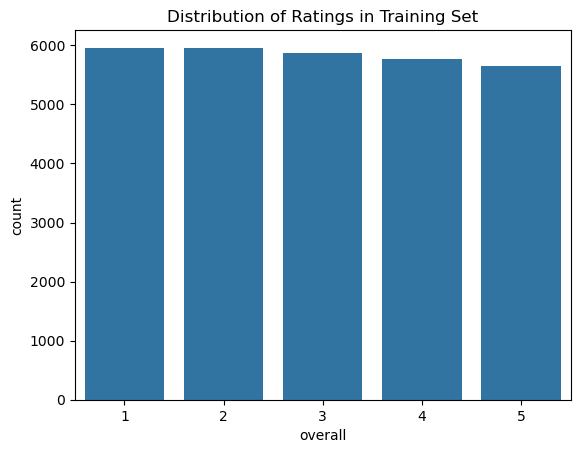

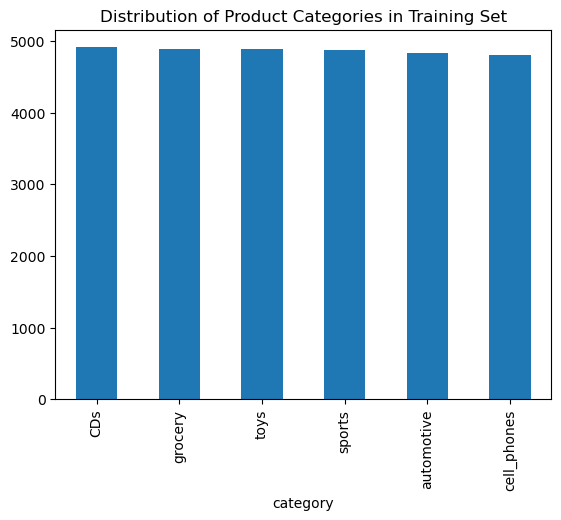

In [3]:
df_train.info()
df_train.isnull().sum()

sns.countplot(data=df_train, x="overall")
plt.title("Distribution of Ratings in Training Set")
plt.show()

# see distribution of categories
df_train["category"].value_counts().plot(kind="bar")
plt.title("Distribution of Product Categories in Training Set")
plt.show()

In [4]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


## 2. Text Preprocessing & Feature Engineering
**Purpose**:
- Convert reviewText into numerical features (e.g. TF-IDF, CountVectorizer)
- (Optional, potentially later) Add metadata features (like verified, vote, text length) to the pipeline
- (Optional, potentially later) Possibly incorporate ngrams or custom text cleaning.

In [5]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer, StandardScaler
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Function to compute length of text review
# def extract_length(text_series):
#     return pd.DataFrame({"review_length": text_series.apply(len)})

# # Function gets number of words in revew
# def extract_num_words(text_series):
#     return pd.DataFrame({"num_words": text_series.apply(lambda x: len(x.split()))})

# # Function to fill missing vote val w/ 0 & -> float
# def handle_vote_col(votes):
#     votes_filled = votes.fillna(0).astype(float)
#     return pd.DataFrame({"vote": votes_filled})

# # Function converts boolean verified column to 0/1
# def handle_verified_col(verified_series):
#     return pd.DataFrame({"verified_numeric": verified_series.astype(int)})

# # ✅ Ensure vote & verified exist in train & test sets
# # df_train["vote"] = df_train["vote"].fillna(0).astype(float)
# # df_train["verified"] = df_train["verified"].astype(int)

# # df_test["vote"] = df_test["vote"].fillna(0).astype(float)
# # df_test["verified"] = df_test["verified"].astype(int)

# # Extract text features with TF-IDF (Term Frequency - Inverse Document Frequency), later used in column transformer
# text_vectorizer = TfidfVectorizer(
#     ngram_range=(1, 2),
#     max_features=10000,
#     stop_words=None,
#     min_df=3,
#     max_df=0.76,
#     sublinear_tf=True,
#     use_idf=True,
#     binary=True,
#     norm=None
# )

# # create transformers for each of the numeric features
# length_transformer = FunctionTransformer(extract_length, validate=False)
# num_words_transformer = FunctionTransformer(extract_num_words, validate=False)
# vote_transformer = FunctionTransformer(handle_vote_col, validate=False)
# verified_transformer = FunctionTransformer(handle_verified_col, validate=False)

# # Create column transformer to combine text + numeric features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("text_tfidf", text_vectorizer, "reviewText"),           # text -> TF-IDF
#         ("length", length_transformer, "reviewText"),
#         #("vote_col", vote_transformer, "vote"),
#         #("verified_col", verified_transformer, "verified"),
#         # uncomment to add num_words feature:
#         ("num_words", num_words_transformer, "reviewText"),
#     ],
#     remainder="drop"
# )


# final_pipeline = Pipeline([
#     ("preprocess", preprocessor),
#     ("scaler", StandardScaler(with_mean=False)),  # Scale numeric data
#     ("clf", LogisticRegression(
#         solver="saga",           # ✅ Explicit solver
#         penalty="l2",            # ✅ L2 regularization
#         max_iter=1000,           # ✅ Prevents convergence issues
#         class_weight="balanced", # ✅ Handles class imbalance
#         C=0.83,
#         tol=1e-3 # ✅ Explicitly set regularization strength
#     ))
# ])

## 3.1 Binary Classification Tasks
The four binary tasks are each defined by a cutoff $c \in {1,2,3,4}$
- Label = 1 if `overall` > c, else 0

### Creating Binary Labels

In [6]:
for cutoff in [1,2,3,4]:
    new_col = f"binary_label_cutoff_{cutoff}"
    df_train[new_col] = (df_train["overall"] > cutoff).astype(int)

# Print class distribution for cutoff=1
print("Class Distribution for Cutoff=1:")
print(df_train["binary_label_cutoff_1"].value_counts(normalize=True))

# Print class distribution for cutoff=2
print("\nClass Distribution for Cutoff=2:")
print(df_train["binary_label_cutoff_2"].value_counts(normalize=True))

# Print class distribution for cutoff=3
print("\nClass Distribution for Cutoff=3:")
print(df_train["binary_label_cutoff_3"].value_counts(normalize=True))

# Print class distribution for cutoff=4
print("\nClass Distribution for Cutoff=4:")
print(df_train["binary_label_cutoff_4"].value_counts(normalize=True))



Class Distribution for Cutoff=1:
binary_label_cutoff_1
1    0.795916
0    0.204084
Name: proportion, dtype: float64

Class Distribution for Cutoff=2:
binary_label_cutoff_2
1    0.591764
0    0.408236
Name: proportion, dtype: float64

Class Distribution for Cutoff=3:
binary_label_cutoff_3
0    0.609065
1    0.390935
Name: proportion, dtype: float64

Class Distribution for Cutoff=4:
binary_label_cutoff_4
0    0.806708
1    0.193292
Name: proportion, dtype: float64


### Training & Cross-Validation
- Select a classifer, logistic regression as baseline
- Define parameter grid for both text vectorizer + classifier hyperparams
- Use 5-fold CV with a metric of `f1_macro`

#### Tune `ngram_range`, `C`, and `max_features`

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

########################################
# sklearn + config
########################################
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import loguniform, randint

################################################
# 1. Load Data
################################################
df_train = pd.read_csv("../data/Training.csv")
df_test  = pd.read_csv("../data/Test.csv")

print("\n[INFO] Columns in df_train:", df_train.columns.tolist())
print("[INFO] Columns in df_test :", df_test.columns.tolist())

################################################
# 2. Create Label: binary_label_cutoff_1
################################################
# For example, label=1 if overall>1 (cutoff=1). 
# If you prefer cutoff=3 => df_train["binary_label_cutoff_1"] = (df_train["overall"]>3).astype(int)
df_train["binary_label_cutoff_1"] = (df_train["overall"] > 1).astype(int)

################################################
# 3. Helper Functions
################################################
def parse_review_time(str_val):
    """Try parse 'MM DD, YYYY' strings. Return NaT if fails."""
    try:
        return datetime.strptime(str_val, "%m %d, %Y")
    except:
        return pd.NaT

def advanced_time_features(df):
    """
    Safely create 'reviewTime_parsed' from 'reviewTime' or fallback to 'unixReviewTime',
    then produce numeric features: 'review_hour','review_weekday','review_days_since'.
    Fills missing with -1 if not parseable.
    """
    # If 'reviewTime' exists, parse
    if "reviewTime" in df.columns:
        df["reviewTime_parsed"] = df["reviewTime"].apply(parse_review_time)
    else:
        df["reviewTime_parsed"] = pd.NaT

    # Fallback to 'unixReviewTime'
    if df["reviewTime_parsed"].isna().all() and "unixReviewTime" in df.columns:
        df["reviewTime_parsed"] = pd.to_datetime(df["unixReviewTime"], unit="s", errors="coerce")

    # Create numeric features if parse worked
    now = datetime.now()
    df["review_hour"]       = df["reviewTime_parsed"].dt.hour.fillna(-1).astype(int)
    df["review_weekday"]    = df["reviewTime_parsed"].dt.weekday.fillna(-1).astype(int)
    df["review_days_since"] = (now - df["reviewTime_parsed"]).dt.days.fillna(-1).astype(int)

    return df

def create_numeric_from_text(df, textcol="reviewText"):
    """Create 'review_length','num_words' from textcol. Fills with -1 if not present."""
    if textcol not in df.columns:
        df["review_length"] = -1
        df["num_words"]     = -1
    else:
        df[textcol] = df[textcol].fillna("")
        df["review_length"] = df[textcol].apply(len)
        df["num_words"]     = df[textcol].apply(lambda x: len(x.split()))
    return df

################################################
# 4. Basic Preprocessing
################################################

# (A) fill numeric columns if missing
df_train["vote"] = df_train.get("vote", 0).fillna(0).astype(float)
df_test["vote"]  = df_test.get("vote", 0).fillna(0).astype(float)

df_train["verified"] = df_train.get("verified", 0).fillna(0).astype(int)
df_test["verified"]  = df_test.get("verified", 0).fillna(0).astype(int)

# (B) create reviewer_freq
if "reviewerID" in df_train.columns:
    freq_map_train = df_train["reviewerID"].value_counts()
    df_train["reviewer_freq"] = df_train["reviewerID"].map(freq_map_train).fillna(1).astype(int)
else:
    df_train["reviewer_freq"] = 1

if "reviewerID" in df_test.columns:
    freq_map_test = df_test["reviewerID"].value_counts()
    df_test["reviewer_freq"] = df_test["reviewerID"].map(freq_map_test).fillna(1).astype(int)
else:
    df_test["reviewer_freq"] = 1

# (C) create time-based features
df_train = advanced_time_features(df_train)
df_test  = advanced_time_features(df_test)

# (D) create review_length, num_words from 'reviewText'
df_train = create_numeric_from_text(df_train, "reviewText")
df_test  = create_numeric_from_text(df_test,  "reviewText")

# (E) fill or create 'category' if not present
if "category" not in df_train.columns:
    df_train["category"] = "unknown"
else:
    df_train["category"] = df_train["category"].fillna("unknown").astype(str)

if "category" not in df_test.columns:
    df_test["category"] = "unknown"
else:
    df_test["category"] = df_test["category"].fillna("unknown").astype(str)

# (F) fill summary, reviewText if missing
df_train["summary"]    = df_train.get("summary","").fillna("")
df_test["summary"]     = df_test.get("summary","").fillna("")
df_train["reviewText"] = df_train.get("reviewText","").fillna("")
df_test["reviewText"]  = df_test.get("reviewText","").fillna("")

################################################
# 5. Final Columns
################################################
text_col    = "reviewText"
summary_col = "summary"
numeric_cols = [
    "vote","verified","review_length","num_words",
    "reviewer_freq","review_hour","review_weekday","review_days_since"
]
cat_cols = ["category"]
label_col = "binary_label_cutoff_1"

# Build final list (only add if present in df_train)
final_columns = []
if text_col in df_train.columns:
    final_columns.append(text_col)
if summary_col in df_train.columns:
    final_columns.append(summary_col)
for c in cat_cols:
    if c in df_train.columns:
        final_columns.append(c)
for c in numeric_cols:
    if c in df_train.columns:
        final_columns.append(c)

# slice train
df_train = df_train[final_columns + [label_col]]

# slice test with common columns
common_test_cols = [c for c in final_columns if c in df_test.columns]
df_test = df_test[common_test_cols]

print("\n[DEBUG] final_columns =>", final_columns)
print("[DEBUG] df_train columns =>", df_train.columns.tolist())
print("[DEBUG] df_test  columns =>", df_test.columns.tolist())

################################################
# 6. Build Pipeline
################################################

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Text pipeline for main reviewText
pipe_text = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        stop_words="english",
        max_features=10000,  # Up from 5k => more features
        min_df=3,
        max_df=0.8,
        sublinear_tf=True,
        norm="l2",
        use_idf=True,
        binary=False
    )),
    ("svd", TruncatedSVD(n_components=150, random_state=42))  # Increased to 150
])

# Tfidf pipeline for summary
pipe_summary = TfidfVectorizer(
    max_features=500,
    stop_words="english"
)

# Numeric pipeline
pipe_numeric = Pipeline([
    ("scaler", StandardScaler())
])

# Put them together
transformers_list = []
if text_col in df_train.columns:
    transformers_list.append(("text_pipe", pipe_text, text_col))
if summary_col in df_train.columns:
    transformers_list.append(("summary_pipe", pipe_summary, summary_col))

# If cat columns exist
if all([c in df_train.columns for c in cat_cols]):
    transformers_list.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols))

# numeric
num_cols_ok = [c for c in numeric_cols if c in df_train.columns]
if num_cols_ok:
    transformers_list.append(("num", pipe_numeric, num_cols_ok))

preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder="drop"
)

# Now define multiple base learners for stacking
log1 = LogisticRegression(
    solver="saga",
    penalty="l2",
    class_weight="balanced",
    max_iter=3000,  # increased to avoid warnings
    C=1.0,
    random_state=42
)
rf1 = RandomForestClassifier(
    n_estimators=60,
    max_depth=12,
    class_weight="balanced_subsample",
    random_state=42
)
gb1 = GradientBoostingClassifier(
    n_estimators=60,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

stack_ensemble = StackingClassifier(
    estimators=[
        ("lr", log1),
        ("rf", rf1),
        ("gb", gb1),
    ],
    final_estimator=LogisticRegression(
        solver="lbfgs",
        class_weight="balanced",
        max_iter=3000,  # also bigger to avoid warnings
        random_state=42
    ),
    passthrough=True,
    cv=5,  # 5-fold for base learners
    n_jobs=-1
)

final_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", stack_ensemble)
])

################################################
# 7. TRAIN/VALID SPLIT
################################################
X = df_train.drop(columns=[label_col])
y = df_train[label_col].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

################################################
# 8. BIG Random Search
################################################
# We'll do a bigger range of param + more n_iter for "exhaustive" run:
param_dist = {
    # RandomForest
    "clf__rf__n_estimators": randint(50, 200),
    "clf__rf__max_depth": [5,8,12,15,None],

    # GradientBoosting
    "clf__gb__n_estimators": randint(50, 200),
    "clf__gb__learning_rate": loguniform(1e-2, 0.2),
    "clf__gb__max_depth": [2,3,4,5],

    # logistic base
    "clf__lr__C": loguniform(1e-2, 5),

    # final LR
    "clf__final_estimator__C": loguniform(1e-2, 5),

    # Possibly tune # of components in SVD
    "preprocess__text_pipe__svd__n_components": [100,150,200,250],
    # Tfidf max_features
    "preprocess__text_pipe__tfidf__max_features": [5000,10000,15000],
    "preprocess__text_pipe__tfidf__ngram_range": [(1,1),(1,2)],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV

search = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_dist,
    n_iter=25,      # More combos => more thorough (could raise to 50 if you want)
    cv=cv,
    scoring="f1_macro",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\n[INFO] Starting big RandomizedSearchCV with ~25 param combos, 5-fold CV.\n"
      "This may take hours depending on hardware and data size.\n")
search.fit(X_train, y_train)

print("\n=== BEST RESULTS ===")
print("Best Params:", search.best_params_)
print(f"Best CV Macro F1: {search.best_score_:.4f}")

best_model = search.best_estimator_

################################################
# 9. EVALUATE ON VALIDATION
################################################
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:,1]  # prob for class=1

val_f1  = f1_score(y_val, y_val_pred, average="macro")
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

print("\n=== VALIDATION METRICS ===")
print(f"Macro F1 : {val_f1:.4f}")
print(f"Accuracy : {val_acc:.4f}")
print(f"ROC AUC  : {val_auc:.4f}")

################################################
# 10. TRAIN FULL + KAGGLE SUB
################################################
# Retrain on full train data
best_model.fit(X, y)

df_test_pred = best_model.predict(df_test)
df_test["binary_split_1"] = df_test_pred

os.makedirs("results", exist_ok=True)
df_test["id"] = df_test.index

out_path = "results/submission_cutoff1_exhaustive.csv"
df_test[["id","binary_split_1"]].to_csv(out_path, index=False)
print(f"\n✅ Done. Kaggle submission => {out_path}")



[INFO] Columns in df_train: ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image', 'style', 'category']
[INFO] Columns in df_test : ['verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image', 'style', 'category']

[DEBUG] final_columns => ['reviewText', 'summary', 'category', 'vote', 'verified', 'review_length', 'num_words', 'reviewer_freq', 'review_hour', 'review_weekday', 'review_days_since']
[DEBUG] df_train columns => ['reviewText', 'summary', 'category', 'vote', 'verified', 'review_length', 'num_words', 'reviewer_freq', 'review_hour', 'review_weekday', 'review_days_since', 'binary_label_cutoff_1']
[DEBUG] df_test  columns => ['reviewText', 'summary', 'category', 'vote', 'verified', 'review_length', 'num_words', 'reviewer_freq', 'review_hour', 'review_weekday', 'review_days_since']

[INFO] Starting big RandomizedSearchCV with ~25 param c

/opt/anaconda3/envs/amazon_reviews/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

### Evaluating the Best Model & Repeating
- Retreiving the best pipeline found via `grid.best_estimator_`
- Generating confusion matrix, ROC curve, AUC, accuracy, macro F1, etc.

In [7]:
print(df_train.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style', 'category', 'binary_label_cutoff_1',
       'binary_label_cutoff_2', 'binary_label_cutoff_3',
       'binary_label_cutoff_4'],
      dtype='object')


In [8]:
# # Import necessary libraries
# import os
# import pandas as pd
# import re
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
# from sklearn.model_selection import train_test_split
# from sklearn.inspection import permutation_importance



# # final_params = {
# #     "preprocess__text_tfidf__ngram_range": (1, 3),
# #     "preprocess__text_tfidf__max_features": 10000,   # limit vocab size for speed
# #     "preprocess__text_tfidf__min_df": 5,  # Filter rare words
# #     "preprocess__text_tfidf__stop_words": None,
# #     "preprocess__text_tfidf__max_df": 0.7,
# #     "preprocess__text_tfidf__sublinear_tf": True,
# #     "preprocess__text_tfidf__norm": None,
# #     "preprocess__text_tfidf__use_idf": True,
# #     "preprocess__text_tfidf__binary": True,
# #     "clf__solver": "saga",
# #     "clf__penalty": "l2",
# #     "clf__max_iter": 2000,
# #     "clf__class_weight": "balanced",
# #     "clf__C": 1
# # }



# # ✅ Split data into training (80%) and validation (20%)
# X_train, X_val, y_train, y_val = train_test_split(
#     df_train[["reviewText"]],  
#     df_train["binary_label_cutoff_1"],
#     test_size=0.2,
#     random_state=42
# )

# # ✅ Train on training set only
# final_pipeline.fit(X_train, y_train)

# # ✅ Evaluate on validation set (instead of full train set!)
# y_val_pred = final_pipeline.predict(X_val)
# y_val_proba = final_pipeline.predict_proba(X_val)[:,1]

# print("\nValidation Performance:")
# print("Macro F1:", f1_score(y_val, y_val_pred, average='macro'))
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("ROC AUC:", roc_auc_score(y_val, y_val_proba))

# # ✅ Compare class distributions
# print("\nTraining Class Distribution:")
# print(df_train["binary_label_cutoff_1"].value_counts(normalize=True))

# print("\nTest Class Distribution (if labels were available):")
# if "binary_label_cutoff_1" in df_test.columns:
#     print(df_test["binary_label_cutoff_1"].value_counts(normalize=True))

# # ✅ Compute feature importance
# result = permutation_importance(final_pipeline, X_val, y_val, n_repeats=5, random_state=42)
# feature_importances = result.importances_mean
# feature_names = ["reviewText_TFIDF", "vote", "verified", "review_length", "num_words"]
# importance_dict = dict(zip(feature_names, feature_importances))
# print("\nFeature Importances:", importance_dict)

# # ✅ Transform test data using trained pipeline
# X_test_transformed = final_pipeline.named_steps["preprocess"].transform(df_test[["reviewText"]])

# # ✅ Compare train/test feature shapes
# print("Train Feature Shape:", final_pipeline.named_steps["preprocess"].transform(X_train).shape)
# print("Test Feature Shape:", X_test_transformed.shape)

# # ✅ Generate predictions for Kaggle submission
# y_test_pred = final_pipeline.predict(df_test[["reviewText"]])
# df_test["binary_split_1"] = y_test_pred

# # make sure results directory exists
# results_dir = "results"
# os.makedirs(results_dir, exist_ok=True)  

# # make sure 'id' column is index of df_test
# df_test["id"] = df_test.index 

# # Find existing versions and determine new version number (thanks ChatGPT)
# base_filename = "submission_cutoff1"
# existing_files = [f for f in os.listdir(results_dir) if re.match(f"{base_filename}_v\d+\.csv", f)]
# existing_versions = [int(re.search(r'_v(\d+)\.csv', f).group(1)) for f in existing_files if re.search(r'_v(\d+)\.csv', f)]
# new_version = max(existing_versions, default=0) + 3

# # new file path
# submission_path = os.path.join(results_dir, f"{base_filename}_v{new_version}.csv")

# # save only 'id' and 'binary_split_1' columns
# df_test[["id", "binary_split_1"]].to_csv(submission_path, index=False)

# print(f"Submission file for Kaggle saved: {submission_path} 🚀")


In [9]:


# # Import necessary libraries
# import os
# import pandas as pd
# import re
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score
# from sklearn.model_selection import train_test_split
# from sklearn.inspection import permutation_importance
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer, StandardScaler

# # ✅ Function to compute length of text review
# def extract_length(text_series):
#     return pd.DataFrame({"review_length": text_series.apply(len)})

# # ✅ Function to compute number of words in review
# def extract_num_words(text_series):
#     return pd.DataFrame({"num_words": text_series.apply(lambda x: len(x.split()))})

# # ✅ Function to fill missing vote values with 0
# def handle_vote_col(votes):
#     return pd.DataFrame({"vote": votes.fillna(0).astype(float)})

# # ✅ Function to convert verified to 0/1
# def handle_verified_col(verified_series):
#     return pd.DataFrame({"verified_numeric": verified_series.astype(int)})

# # ✅ Ensure vote & verified exist in train & test sets
# # df_train["vote"] = df_train["vote"].fillna(0).astype(float)
# # df_train["verified"] = df_train["verified"].astype(int)

# # df_test["vote"] = df_test["vote"].fillna(0).astype(float)
# # df_test["verified"] = df_test["verified"].astype(int)

# # ✅ Define TF-IDF vectorizer
# text_vectorizer = TfidfVectorizer(
#     ngram_range=(1, 2),
#     max_features=10000,
#     stop_words=None,
#     min_df=3,
#     max_df=0.85,
#     sublinear_tf=True,
#     use_idf=True,
#     binary=False
# )

# # ✅ Create column transformers for text & numeric features
# length_transformer = FunctionTransformer(extract_length, validate=False)
# num_words_transformer = FunctionTransformer(extract_num_words, validate=False)
# vote_transformer = FunctionTransformer(handle_vote_col, validate=False)
# verified_transformer = FunctionTransformer(handle_verified_col, validate=False)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("text_tfidf", text_vectorizer, "reviewText"),
#         ("length", length_transformer, "reviewText"),
#         ("num_words", num_words_transformer, "reviewText"),
#         #("vote_col", vote_transformer, "vote"),
#         #("verified_col", verified_transformer, "verified")
#     ],
#     remainder="drop"
# )

# # ✅ Define the final pipeline with all necessary hyperparameters
# final_pipeline = Pipeline([
#     ("preprocess", preprocessor),
#     ("scaler", StandardScaler(with_mean=False)),  # Scale numeric data
#     ("clf", LogisticRegression(
#         solver="saga",           # ✅ Explicit solver
#         penalty="l1",            # ✅ L2 regularization
#         max_iter=2000,           # ✅ Prevents convergence issues
#         class_weight="balanced", # ✅ Handles class imbalance
#         C=2.595942550311263, # ✅ Explicitly set regularization strength
#         tol=1e-3
#     ))
# ])

# # ✅ Split data into training (80%) and validation (20%)
# X_train, X_val, y_train, y_val = train_test_split(
#     df_train[["reviewText"]],
#     df_train["binary_label_cutoff_1"],
#     test_size=0.2,
#     random_state=42
# )

# # ✅ Train on training set only
# final_pipeline.fit(X_train, y_train)

# # ✅ Evaluate on validation set (instead of full train set!)
# y_val_pred = final_pipeline.predict(X_val)
# y_val_proba = final_pipeline.predict_proba(X_val)[:,1]

# print("\nValidation Performance:")
# print("Macro F1:", f1_score(y_val, y_val_pred, average='macro'))
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("ROC AUC:", roc_auc_score(y_val, y_val_proba))

# # ✅ Compare class distributions
# print("\nTraining Class Distribution:")
# print(df_train["binary_label_cutoff_1"].value_counts(normalize=True))

# print("\nTest Class Distribution (if labels were available):")
# if "binary_label_cutoff_1" in df_test.columns:
#     print(df_test["binary_label_cutoff_1"].value_counts(normalize=True))

# # ✅ Compute feature importance
# result = permutation_importance(final_pipeline, X_val, y_val, n_repeats=5, random_state=42)
# feature_importances = result.importances_mean
# feature_names = ["reviewText_TFIDF", "vote", "verified", "review_length", "num_words"]
# importance_dict = dict(zip(feature_names, feature_importances))
# print("\nFeature Importances:", importance_dict)

# # ✅ Transform test data using trained pipeline
# X_test_transformed = final_pipeline.named_steps["preprocess"].transform(df_test[["reviewText"]])

# # ✅ Compare train/test feature shapes
# print("Train Feature Shape:", final_pipeline.named_steps["preprocess"].transform(X_train).shape)
# print("Test Feature Shape:", X_test_transformed.shape)

# # ✅ Generate predictions for Kaggle submission
# y_test_pred = final_pipeline.predict(df_test[["reviewText"]])
# df_test["binary_split_1"] = y_test_pred

# # ✅ Save results for Kaggle
# results_dir = "results"
# os.makedirs(results_dir, exist_ok=True)  
# df_test["id"] = df_test.index 

# base_filename = "submission_cutoff1"
# existing_files = [f for f in os.listdir(results_dir) if re.match(f"{base_filename}_v\d+\.csv", f)]
# existing_versions = [int(re.search(r'_v(\d+)\.csv', f).group(1)) for f in existing_files if re.search(r'_v(\d+)\.csv', f)]
# new_version = max(existing_versions, default=0) + 1
# submission_path = os.path.join(results_dir, f"{base_filename}_v{new_version}.csv")

# df_test[["id", "binary_split_1"]].to_csv(submission_path, index=False)
# print(f"Submission file for Kaggle saved: {submission_path} 🚀")


In [10]:
!pip install scikit-optimize

In [11]:
from skopt import BayesSearchCV

In [16]:
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import loguniform, randint

########################
# 1. LOAD DATA
########################

# Load datasets (update paths if necessary)
df_train = pd.read_csv("../data/Training.csv")
df_test = pd.read_csv("../data/Test.csv")

# Verify correct loading
print("Training Data Sample:\n", df_train.head())
print("Test Data Sample:\n", df_test.head())

########################
# 2. HELPER FUNCTIONS
########################

def extract_length(text_series):
    return pd.DataFrame({"review_length": text_series.apply(len)})

def extract_num_words(text_series):
    return pd.DataFrame({"num_words": text_series.apply(lambda x: len(str(x).split()))})

def extract_review_time_features(df):
    """Generate time-based features from review timestamps."""
    df["reviewTime"] = pd.to_datetime(df["reviewTime"], errors="coerce")  # Ensure datetime format
    df["review_hour"] = df["reviewTime"].dt.hour.fillna(-1)  # Hour of day
    df["review_weekday"] = df["reviewTime"].dt.weekday.fillna(-1)  # Day of week (0=Monday, 6=Sunday)
    df["review_days_since"] = (datetime.now() - df["reviewTime"]).dt.days.fillna(-1)  # Days since review
    return df

########################
# 3. DATA PREPROCESSING
########################

df_train["vote"] = df_train["vote"].fillna(0).astype(float)
df_train["verified"] = df_train["verified"].fillna(0).astype(int)
df_train["reviewer_freq"] = df_train["reviewerID"].map(df_train["reviewerID"].value_counts())  # Count reviews per user

df_test["vote"] = df_test["vote"].fillna(0).astype(float)
df_test["verified"] = df_test["verified"].fillna(0).astype(int)
df_test["reviewer_freq"] = df_test["reviewerID"].map(df_test["reviewerID"].value_counts())

df_train = extract_review_time_features(df_train)
df_test = extract_review_time_features(df_test)

########################
# 4. COLUMN TRANSFORMER (TEXT + NUMERIC)
########################

text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=8000,  # Smaller for speed
        stop_words="english",
        min_df=3,
        max_df=0.75,
        sublinear_tf=True,
        norm="l2",
        use_idf=True,
        binary=False
    )),
    ("svd", TruncatedSVD(n_components=150, random_state=42))  # Lighter dimensionality reduction
])

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text_svd", text_pipeline, "reviewText"),
        ("summary_tfidf", TfidfVectorizer(max_features=300, stop_words="english"), "summary"),
        ("category", OneHotEncoder(handle_unknown="ignore"), ["category"]),
        ("numeric", numeric_pipeline, ["vote", "verified", "review_length", "num_words", "reviewer_freq", "review_hour", "review_weekday", "review_days_since"])
    ]
)

########################
# 5. STACKING CLASSIFIER (LIGHT VERSION)
########################

base_lr = LogisticRegression(
    solver="saga",
    penalty="l2",
    class_weight="balanced",
    max_iter=1000,
    C=0.8,
    random_state=42
)

base_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight="balanced_subsample",
    random_state=42
)

stack_ensemble = StackingClassifier(
    estimators=[
        ("lr", base_lr),
        ("rf", base_rf),
    ],
    final_estimator=LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ),
    passthrough=True,
    cv=3,  # Faster than 5-fold
    n_jobs=-1
)

########################
# 6. FINAL PIPELINE
########################

final_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", stack_ensemble)
])

########################
# 7. TRAIN/VALIDATION SPLIT
########################

X = df_train[["reviewText", "summary", "category", "vote", "verified", "review_length", "num_words", "reviewer_freq", "review_hour", "review_weekday", "review_days_since"]]
y = df_train["binary_label_cutoff_1"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

########################
# 8. RANDOM SEARCH (LIGHT VERSION)
########################

param_dist = {
    "clf__rf__n_estimators": randint(30, 100),
    "clf__rf__max_depth": [5, 10, 15, None],
    "clf__lr__C": loguniform(0.1, 2.0),
    "clf__final_estimator__C": loguniform(0.1, 2.0),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Small search for speed
    cv=cv,
    scoring="f1_macro",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

########################
# 9. LAUNCH QUICK RANDOM SEARCH
########################

print("🚀 Running Quick RandomizedSearchCV (n_iter=5 * 3 folds)...\n")
search.fit(X_train, y_train)

print("\n=== BEST RESULTS ===")
print("Best Params:", search.best_params_)
print(f"Best CV F1 Macro: {search.best_score_:.4f}")

########################
# 10. EVALUATE ON VALIDATION
########################

best_model = search.best_estimator_

y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_pro



Training Data Sample:
    overall  verified   reviewTime                        reviewerID  \
0        1     False  11 12, 2016  C413C78E10E54C5DB41837889F36C1E8   
1        1      True   12 6, 2016  490AE37808EFEE3AF4FE6DEBDEB5A4C8   
2        1      True  09 17, 2014  74A9FA5A64449BEE2A2E8E3F62872F0F   
3        1      True  06 11, 2016  EB561158A2829D98B467FE03CC1E45F1   
4        1      True  12 23, 2017  5045D801332850D21618DD13A697CD9B   

                               asin                      reviewerName  \
0  565D194F38B1CC3F806EE677C61F639C  465E154EC79AFFAB5EB2607198B21433   
1  0D66512A0A7F580523AB996378DF0F14  760C63E8E5E8DC3FAA01878D37BA5678   
2  A0E45600FF2C5A779CB4314F379C253A  C6E4DD5C1C4EC09E90182644ED6CA9EF   
3  37AB9A82470595E0ACB88BAC48C150EE  F4892A77EA45C52F40AB17ED537EF9FF   
4  5772FF30428EEB8E0258C1A53CA2EC50  522F0BBFF2B47F1D63FF781A0AB1D079   

                                          reviewText  \
0      all of the reviews for this product are fake.   

KeyError: 'reviewerId'

In [14]:
print("Columns in df_train:", df_train.columns)
print("Columns in df_test:", df_test.columns)


Columns in df_train: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style', 'category'],
      dtype='object')
Columns in df_test: Index(['verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'image', 'style',
       'category'],
      dtype='object')
